In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from localGD import localGD
import time
import imageio
from utils import *
from torch.quasirandom import SobolEngine
import sobol_seq

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.sincos(Noise, Noise_level)
# objective = f_class.Branin(Noise, Noise_level)
# objective = f_class.Keane(Noise, Noise_level)
# objective = f_class.Rosenbrock_2(Noise, Noise_level)  
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level)
# objective = f_class.quad(Noise, Noise_level)
# objective = f_class.Eggholder(Noise, Noise_level)
# objective = f_class.Rastrigin(Noise, Noise_level, dim=2)


f = objective.func
clean_f = lambda x: f_class.sincos().func(x)
# clean_f = lambda x: f_class.Branin().func(x)
# clean_f = lambda x: f_class.Keane().func(x)
# clean_f = lambda x: f_class.Rosenbrock_2().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
clean_f = lambda x: f_class.Ackley_2().func(x)  
# clean_f = lambda x: f_class.Schwefel().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Levy().func(x)
# clean_f = lambda x: f_class.quad().func(x)
# clean_f = lambda x: f_class.Eggholder().func(x)
# clean_f = lambda x: f_class.Rastrigin().func(x)

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]
# print(f( np.array([1, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-4.  3.]
 [-4.  3.]]
dim:  2


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=3000)
# del gp
# (ls, var)

#### Grid & Plot

In [6]:
# creating meshgrid to plot over entire range
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

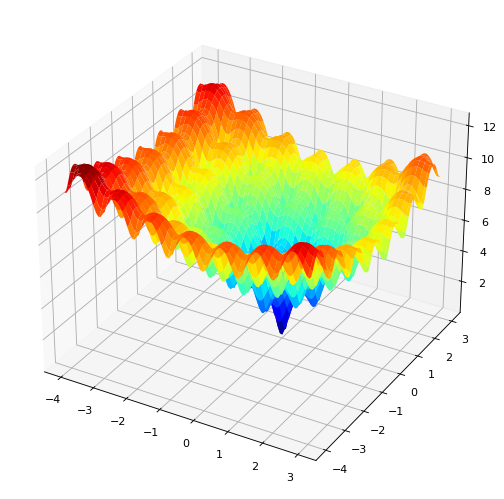

(10000, 1)

In [7]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(Grid).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()
f(Grid).shape

In [8]:
# 3d plot of the gradient
# approximate the gradient
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
approx_grad.shape
g1 = approx_grad[:, 0]
g2 = approx_grad[:, 1]
g1, g2

(array([-0.89865756,  2.5995425 ,  4.61535585, ..., -4.42426991,
        -2.40433598,  1.09762371]),
 array([-0.89865756, -0.91303945, -0.92758942, ...,  1.13960111,
         1.11846769,  1.09762371]))

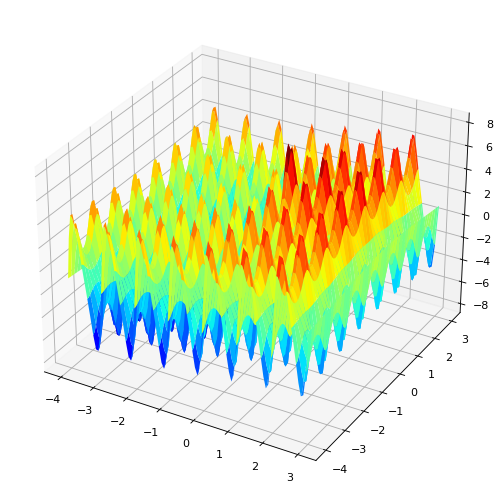

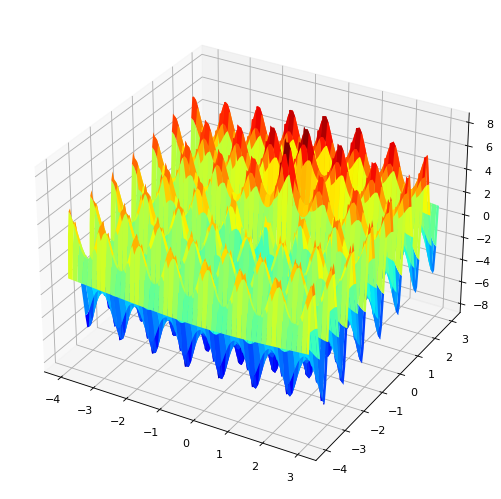

In [9]:
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g1.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g2.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# *BO Test*

In [10]:
MAX = 150 # function observations

## GD

#### Set up

In [11]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
# w = X[np.argmin(f(X))].reshape(1, dim)

# # sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)
# X_fix = X

In [12]:
gp = GP_grad(B, Noise, Noise_level, compress=True)
# gp.set_hyper(ls, var) # if online, skip

gp.set_data(X, f(X))

gp.optimize()
gp.fit()

history_w = []
history_full_w = []
history_f = []

##### warm up with UCB

In [13]:
# warmup = 3
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

##### warm up with TS

In [14]:
warmup = 10
history_warmup = []
for i in range(1, warmup+1):
    w = gp.thompson_sample(n_mesh=2000)    
    X = np.vstack([X, w])
    
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    gp.add_data(w.reshape(1, dim), f(w))
    
    if i % 3 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [-2.50759549 -1.34867117], f(w):  8.893685454975767, 
2, w:  [-2.17215902 -1.71158814], f(w):  8.069651248934507, 
3, w:  [-1.78120339 -2.16991118], f(w):  7.868981513780405, 
  # Optimal (ls, var) =  (0.6413543683289227, 1.2003276599299408)
4, w:  [2.30917978 0.18976545], f(w):  7.303152260174395, 
5, w:  [ 1.2910561  -2.26220948], f(w):  8.033754851412894, 
6, w:  [-0.56068188 -1.66466054], f(w):  6.630552999859535, 
  # Optimal (ls, var) =  (0.6346760541111853, 1.1610308500379225)
7, w:  [ 2.92036325 -0.86222625], f(w):  7.572036425929406, 
8, w:  [ 0.36880827 -1.79087901], f(w):  6.466841695253631, 
9, w:  [-0.3432712  -0.85922614], f(w):  4.130194383323381, 
  # Optimal (ls, var) =  (1.0, 1.3677522705907943)
10, w:  [ 0.65730619 -0.6682584 ], f(w):  4.607173260145597, 


In [15]:
# # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# x = Grid[:,0]
# y = Grid[:,1]

# # Posterior
# mu, covar = gp.posterior(Grid)
# mu = np.squeeze(mu)
# s = np.sqrt(np.diag(covar))

# fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# # plot function
# im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
# fig.colorbar(im, ax=ax2)

# im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
# im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# # im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

# pl.clabel(im1, inline=True, fontsize=8)

# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax1)

# ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")
# pl.show()

In [16]:
# pl.figure(figsize=(13, 8), dpi=80)
# pl.plot(np.squeeze(np.array(history_warmup)[:, 1]), "-^")
# pl.xlabel("cost")
# pl.ylabel("function value")
# pl.grid(True)

##### optimize with GD

In [17]:
w = gp.X[np.argmin(gp.y)]
GD = localGD(gp, B, w, f)

In [18]:
gp.posterior(w), gp._normal(f(w))
# gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

((array([[-1.92801994]]), array([[9.99999927e-09]])), array([[-1.92801996]]))

In [19]:
gp.posterior_full_grad('full', dim*[w]), gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))

((array([[-0.67908077],
         [-0.99024957]]),
  array([[ 0.41607827, -0.10550226],
         [-0.10550226,  0.38773993]])),
 array([-2.28788465,  0.14175303]))

In [20]:
gp.optimize()
np.set_printoptions(precision=4)
cost = setup + warmup
desc = - GD._grad()

while cost <= MAX:
    # update w 
    if GD.FAIL >= GD.STOP:
        print()
        print('New Local Search ---------- ',)
        print('FAIL = ', GD.FAIL, end = ', ')
        print('Norm = ', LA.norm(desc))
        
        # random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))

        # UCB draw
#         b = (cost)**4
#         w, _ = gp.ucb_minimize(b)

        # Thompson Sampling draw
        w = gp.thompson_sample(n_mesh=2000)
        print('    Normal f(w): %.4f ' % gp._normal(f(w).item()) )
        print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(w))
        
        gp.add_data(w.reshape(1, -1), f(w))
        
        # change back setting
        history_w.append(GD.history_w)
        history_f.append([f(w).item() for w in GD.history_w])
        GD = localGD(gp, B, w, f)
        cost += 1
    else:
        w, path = GD.update(commit=True)
        
        print('    Normal f(w): %.4f ' % gp._normal(f(w).item()) )
        print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(w))
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
        
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    

    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('     d(w): ', np.squeeze(m), end = ', ')
    print('    s.d: ', np.squeeze(v), end = ', ')
    print('    g(w):', gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)))
    print()
           
print('Max Cost reached = ', cost)
history_w.append(GD.history_w)
history_f.append([f(w).item() for w in GD.history_w])

    Normal f(w): -2.3094 
    Predict f(w): (-2.1557, 0.0242) 
  # Optimal (ls, var) =  (1.0, 0.8556337920692866)
12.     w:  [-0.1517 -0.6353],     f(w): 3.522506 
     d(w):  [-0.2863 -0.7754],     s.d:  [0.3709 0.3959],     g(w): [-1.6682 -0.1312]

    Normal f(w): -2.4685 
    Predict f(w): (-1.9759, 0.0168) 
13.     w:  [-0.0794 -0.319 ],     f(w): 2.369530 
     d(w):  [ 0.617  -1.7921],     s.d:  [0.3937 0.1083],     g(w): [-1.1908 -2.9061]

    Normal f(w): -2.4980 
    Predict f(w): (-2.5923, 0.0198) 
14.     w:  [-0.1373  0.1167],     f(w): 1.214415 
     d(w):  [ 0.1658 -0.4422],     s.d:  [0.6369 0.1588],     g(w): [-2.7858  2.4277]

    Normal f(w): -1.7530 
    Predict f(w): (-2.0294, 0.0014) 
  # Optimal (ls, var) =  (0.5146309280846485, 0.7248103540150499)
15.     w:  [-0.109   0.2264],     f(w): 1.830444 
     d(w):  [1.8115 2.1885],     s.d:  [1.2685 0.4445],     g(w): [-1.6533  2.816 ]


New Local Search ---------- 
FAIL =  1, Norm =  1.200726828059987
    Normal f(w

    Normal f(w): 0.5437 
    Predict f(w): (0.6396, 0.0350) 
50.     w:  [ 2.8751 -1.2522],     f(w): 8.467888 
     d(w):  [-0.1984 -1.5891],     s.d:  [0.9313 0.5307],     g(w): [-0.4521 -1.5828]

    Normal f(w): 0.2931 
    Predict f(w): (0.3356, 0.0157) 
  # Optimal (ls, var) =  (0.2591388172831927, 0.5031229777135255)
51.     w:  [ 2.887  -1.1132],     f(w): 7.672532 
     d(w):  [-0.0608 -1.3968],     s.d:  [1.9882 0.3045],     g(w): [-0.824  -1.5555]

    Normal f(w): 0.2145 
    Predict f(w): (0.2344, 0.0005) 
52.     w:  [ 2.8994 -1.0651],     f(w): 7.428335 
     d(w):  [-1.465  -0.9635],     s.d:  [1.4945 0.406 ],     g(w): [-0.8366 -1.1189]

    Normal f(w): 0.1558 
    Predict f(w): (0.0374, 0.0256) 
53.     w:  [ 3.     -1.0272],     f(w): 7.247340 
     d(w):  [ 0.0055 -0.3914],     s.d:  [0.604  0.8361],     g(w): [ 0.538  -0.6383]

    Normal f(w): 0.1340 
    Predict f(w): (0.1472, 0.0005) 
  # Optimal (ls, var) =  (0.4725707616663492, 47.84879899629469)
54.     w:  

    Normal f(w): 0.8564 
    Predict f(w): (0.7721, 2.7008) 
88.     w:  [ 1.072 -4.   ],     f(w): 8.998286 
     d(w):  [0.3282 0.3688],     s.d:  [5.8937 5.28  ],     g(w): [ 1.1467 -0.4409]

    Normal f(w): 0.8026 
    Predict f(w): (0.8386, 0.0697) 
89.     w:  [ 1.0081 -4.    ],     f(w): 8.841497 
     d(w):  [0.2564 0.172 ],     s.d:  [0.9376 4.5364],     g(w): [ 0.2379 -0.4446]

    Normal f(w): 0.7925 
    Predict f(w): (0.7938, 0.0007) 
  # Optimal (ls, var) =  (0.1678351868780134, 0.4302099818879312)
90.     w:  [ 0.9853 -3.9968],     f(w): 8.832247 
     d(w):  [-0.0387  0.2806],     s.d:  [0.3453 2.0183],     g(w): [-0.1185 -0.3973]


New Local Search ---------- 
FAIL =  1, Norm =  1.200726828059987
    Normal f(w): 0.0628 
    Predict f(w): (0.0004, 0.4302) 
91.     w:  [1.9017 1.1903],     f(w): 6.350251 
     d(w):  [0.0039 0.0074],     s.d:  [3.908 3.908],     g(w): [-0.4508  1.8644]

    Normal f(w): -0.0331 
    Predict f(w): (0.0596, 0.0364) 
92.     w:  [1.914  1

    Normal f(w): -1.7575 
    Predict f(w): (-1.7563, 0.0000) 
124.     w:  [0.0026 0.0028],     f(w): 0.011300 
     d(w):  [0.077  0.0282],     s.d:  [0.028  0.0162],     g(w): [0.6018 0.6553]

    Normal f(w): -1.7301 
    Predict f(w): (-1.7280, 0.0000) 
125.     w:  [0.0014 0.0022],     f(w): 0.007613 
     d(w):  [0.2739 0.1297],     s.d:  [0.0274 0.0139],     g(w): [0.4483 0.7383]

    Normal f(w): -1.7007 
    Predict f(w): (-1.7025, 0.0000) 
  # Optimal (ls, var) =  (0.22593996907738317, 28.12097775545096)
126.     w:  [-5.0206e-03  9.2474e-05],     f(w): 0.014874 
     d(w):  [-0.2904 -0.0777],     s.d:  [0.0184 0.0078],     g(w): [-0.894   0.0165]


New Local Search ---------- 
FAIL =  1, Norm =  1.200726828059987
    Normal f(w): -0.5341 
    Predict f(w): (-19.6611, 16.8557) 
127.     w:  [ 0.2866 -0.6494],     f(w): 3.964365 
     d(w):  [ 40.6471 -77.347 ],     s.d:  [18.675  15.5391],     g(w): [ 0.8877 -0.1903]

    Normal f(w): -0.5546 
    Predict f(w): (-4.3887, 0.3

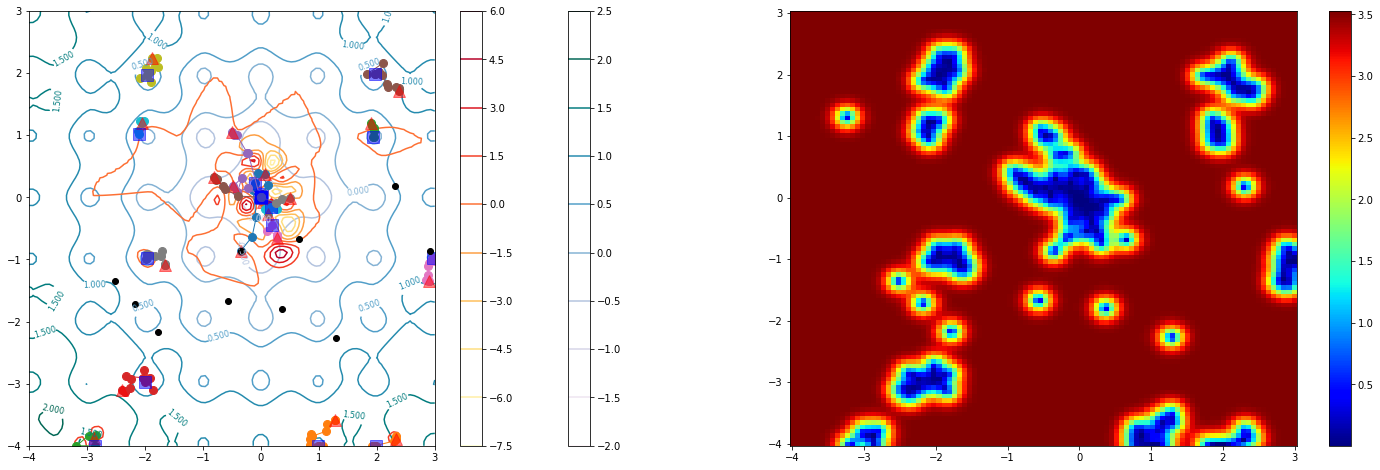

In [21]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
x = Grid[:,0]
y = Grid[:,1]

# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, gp._normal(clean_f(Grid)).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

for lw in history_w:
    array_w = np.vstack(lw)
    ax1.plot(array_w[:, 0], array_w[:, 1], 'o-', linewidth=1, markersize=8)
    ax1.plot(array_w[0][0], array_w[0][1], "r^", markersize=12, alpha=0.5)
    ax1.plot(array_w[-1][0], array_w[-1][1], "bs", markersize=12, alpha=0.5)


UCBwarmup = np.vstack([point[0] for point in history_warmup])
ax1.plot(UCBwarmup[:, 0], UCBwarmup[:, 1], 'ko', linewidth=2)
# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")

# plot derivative
#     p1 = y*np.cos(y)* ( (2*x*np.cos(x)) - np.sin(x) ) / (2* (x*y)**(3/2))
#     p2 = - x*np.sin(x)* ( (2*y*np.sin(y)) + np.cos(y) ) / (2* (x*y)**(3/2))
#     p1 = np.cos(x)*np.cos(y)
#     p2 = -np.sin(x)*np.sin(y)

#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, p1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, p2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")
# Saving all the plots in 2D_Plots (need to creat a folder) 
pl.show()

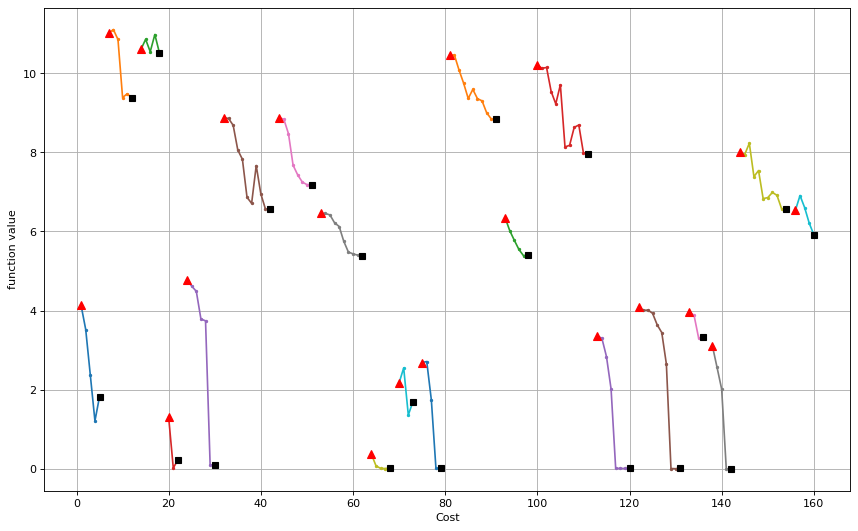

In [22]:
pl.figure(figsize=(13, 8), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=2)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + setup # COST includes setup

pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [23]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([-0.001 ,  0.0013]), 0.004682659834845726, 133)

In [24]:
gp.get_hyper()

{'var': 12.438225122049374, 'lengthscale': 0.18849462285674146}

In [25]:
gp.get_normal()

(5.739415750132804, 3.313375815987605)

In [26]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *UCB*

In [27]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = []

In [28]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=2000)
    
    # 2. GP_UCB/EI
#     b = np.log(cost**gp.dim)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    print('    Normal f(w): %.4f ' % gp._normal(f(w).item()) )
    print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(w))
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

11, w:  [-1.4356  2.5894], f(w):  9.14673544751179, 
    Normal f(w): 1.2202 
    Predict f(w): (0.1264, 1.0513) 
12, w:  [-0.0162 -0.9373], f(w):  2.5921713137072264, 
    Normal f(w): -2.9504 
    Predict f(w): (-2.0344, 0.0211) 
  # Optimal (ls, var) =  (0.5807583005821256, 0.7793482244498607)
13, w:  [ 0.0919 -1.0843], f(w):  3.230176115860243, 
    Normal f(w): -1.8761 
    Predict f(w): (-2.1751, 0.0261) 
14, w:  [ 0.1282 -0.4943], f(w):  3.253705532942455, 
    Normal f(w): -1.6052 
    Predict f(w): (-2.0449, 0.1318) 
15, w:  [-3.4494 -2.7961], f(w):  11.32733614399816, 
    Normal f(w): 2.1340 
    Predict f(w): (0.0125, 0.7792) 
  # Optimal (ls, var) =  (0.5125460775425466, 0.6874846985169266)
16, w:  [0.9556 1.2008], f(w):  4.736945796918967, 
    Normal f(w): -0.8299 
    Predict f(w): (0.0010, 0.6875) 
17, w:  [-3.9756 -0.7128], f(w):  9.961353329781254, 
    Normal f(w): 1.3359 
    Predict f(w): (0.0088, 0.6874) 
18, w:  [1.8382 1.1167], f(w):  6.077450193586245, 
    No

72, w:  [1.5764 1.2007], f(w):  6.8587330886653035, 
    Normal f(w): 0.1491 
    Predict f(w): (-0.0420, 0.5445) 
  # Optimal (ls, var) =  (0.19646276568695864, 0.6405124013479864)
73, w:  [ 2.5276 -3.7809], f(w):  11.532953364006953, 
    Normal f(w): 1.6150 
    Predict f(w): (0.0280, 0.6400) 
74, w:  [-0.1774  0.0218], f(w):  1.1721317823052044, 
    Normal f(w): -1.6411 
    Predict f(w): (-1.9970, 0.0202) 
75, w:  [1.3078 2.1358], f(w):  7.519695793263605, 
    Normal f(w): 0.3482 
    Predict f(w): (0.0001, 0.6405) 
  # Optimal (ls, var) =  (0.18850562570749782, 0.6364950040730807)
76, w:  [-0.0953  0.3399], f(w):  2.5359612921719514, 
    Normal f(w): -1.1942 
    Predict f(w): (-1.6283, 0.1320) 
77, w:  [0.8675 0.3348], f(w):  4.096685913761249, 
    Normal f(w): -0.6946 
    Predict f(w): (0.0009, 0.6365) 
78, w:  [ 1.7036 -0.2889], f(w):  6.28688868801499, 
    Normal f(w): -0.0108 
    Predict f(w): (0.0017, 0.6365) 
  # Optimal (ls, var) =  (0.18666751798053285, 0.64211172

  # Optimal (ls, var) =  (0.19222758183445599, 0.5949293189013791)
133, w:  [-1.8524 -3.3553], f(w):  10.093912580840325, 
    Normal f(w): 1.1699 
    Predict f(w): (0.0746, 0.5900) 
134, w:  [-2.0122 -0.9897], f(w):  5.441918229549554, 
    Normal f(w): -0.3751 
    Predict f(w): (0.0085, 0.5949) 
135, w:  [-3.3217  1.9572], f(w):  9.821872318551673, 
    Normal f(w): 1.0761 
    Predict f(w): (0.0212, 0.5947) 
  # Optimal (ls, var) =  (0.2746104946355031, 33.17047643346962)
136, w:  [-1.4961 -0.7644], f(w):  6.313232296087332, 
    Normal f(w): -0.0930 
    Predict f(w): (-0.1077, 32.4821) 
137, w:  [ 2.5229 -0.9046], f(w):  8.106581618231921, 
    Normal f(w): 0.5027 
    Predict f(w): (0.1988, 20.7978) 
138, w:  [ 2.7566 -3.9857], f(w):  10.960246003861451, 
    Normal f(w): 1.4504 
    Predict f(w): (0.8372, 23.5657) 
  # Optimal (ls, var) =  (0.1941268584953729, 0.5870956766497322)
139, w:  [2.0176 1.3455], f(w):  7.285720043650064, 
    Normal f(w): 0.2159 
    Predict f(w): (0

<ipython-input-29-4188014ce645>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
<ipython-input-29-4188014ce645>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)


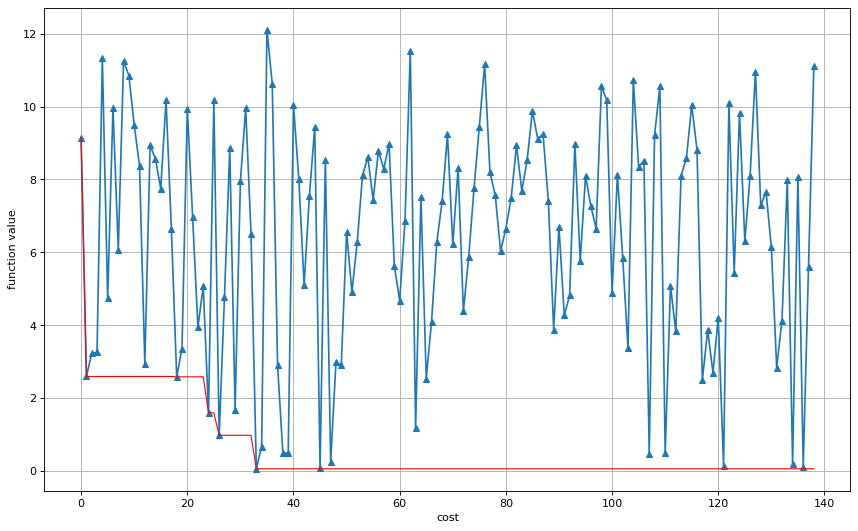

In [29]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)
pl.ylabel("function value")
pl.grid(True)

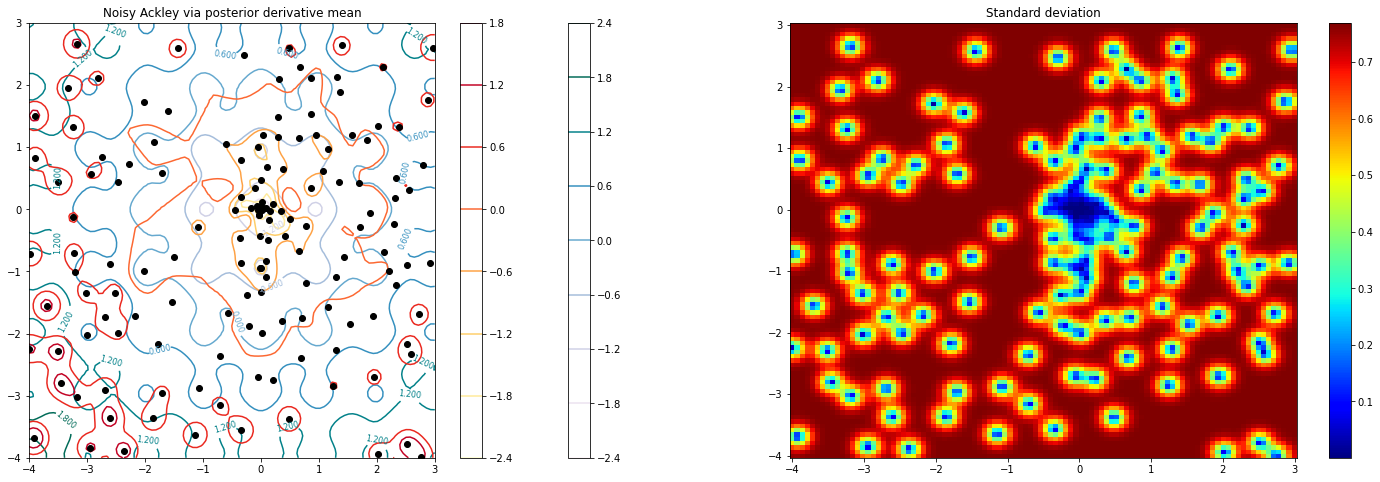

In [30]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, gp._normal(clean_f(Grid)).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

## Global Minima 

In [31]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([-0.0149,  0.0091]), 0.057649978987651895)

In [32]:
gp.get_hyper()

{'var': 0.5917876516803828, 'lengthscale': 0.17796058704498885}